Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Напишите в комментариях к уроку, какого результата вы добились от нейросети, что помогло улучшить её точность?

Используем в данной работе датасет из рентгеновских изображений грудной клетки для построения бинарной сегментации легочных полей лёгких

In [5]:
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

image_path = os.path.join("h:\\X-rey\\Lung Segmentation\\CXR_png\\")
mask_path = os.path.join("h:\\X-rey\\Lung Segmentation\\masks\\")

### Подготовка данных

In [6]:
images = os.listdir(image_path)
#print(images)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [7]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:",len(check))

Total mask that has modified name: 566


In [8]:
testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = check

def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    
    if flag == "test":
        for i in tqdm(testing_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]
            
            im_array.append(im)
            mask_array.append(mask)
        
        return im_array,mask_array
    
    if flag == "train":
        for i in tqdm(training_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)
        
        print(np.shape(im_array),np.shape(mask_array))
        return im_array,mask_array

In [9]:
#perform sanity check

def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()

In [10]:
dim = 112
X_train,y_train = getData(dim,flag="train")
X_test, y_test = getData(dim)

100%|██████████| 566/566 [02:56<00:00,  3.22it/s]


(566, 112, 112) (566, 112, 112)


100%|██████████| 138/138 [01:46<00:00,  1.30it/s]


training set


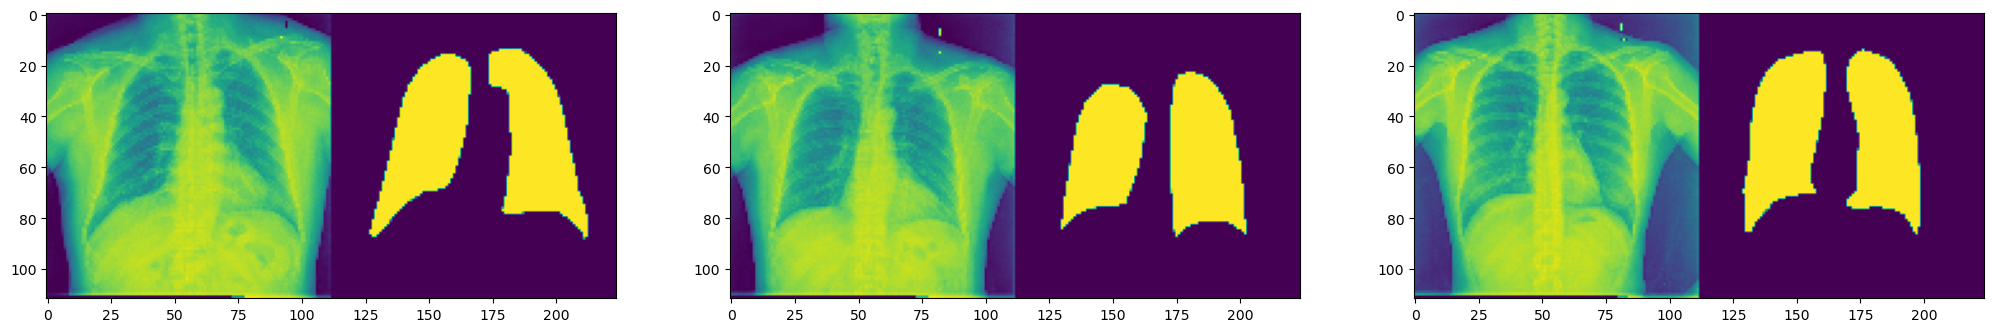

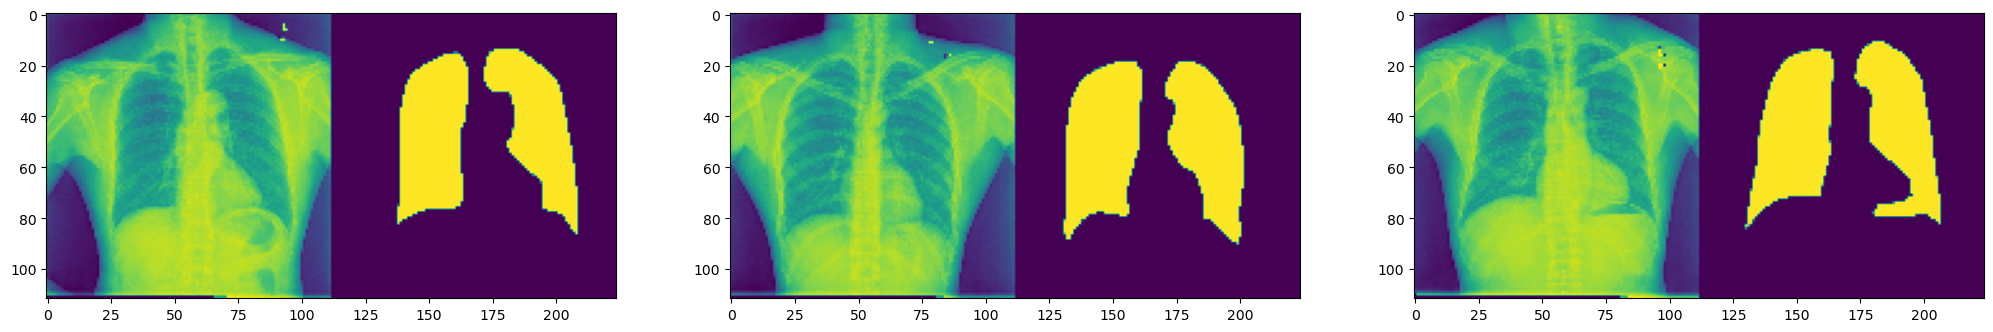

testing set


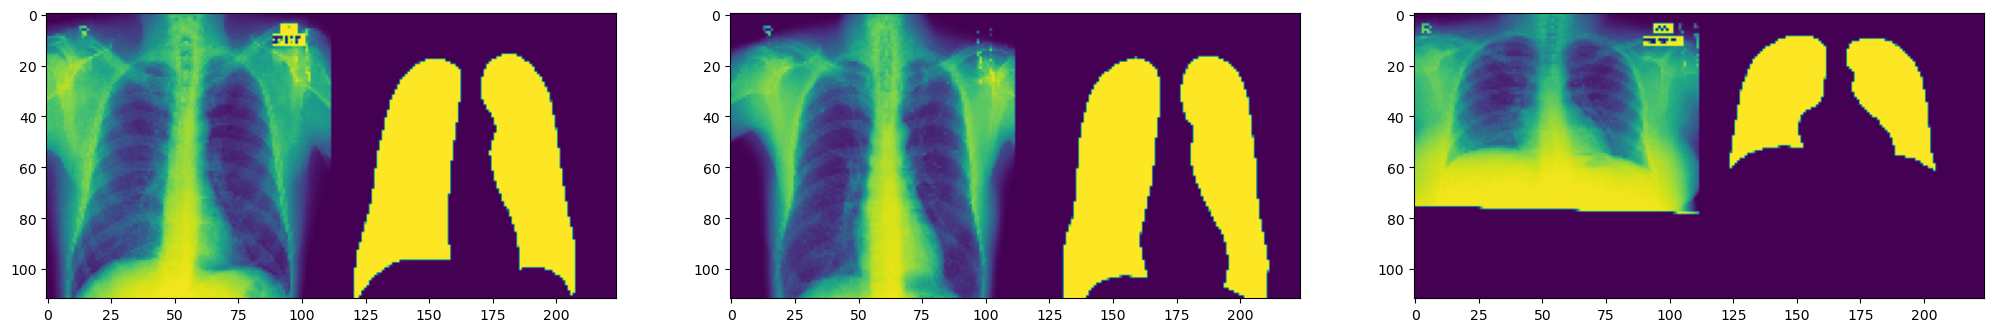

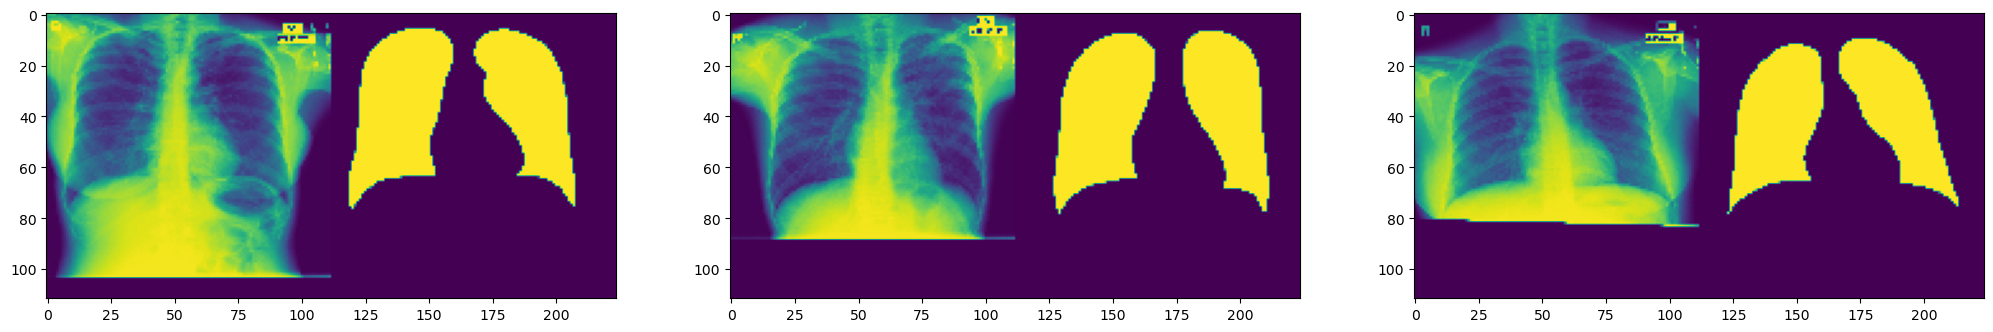

In [11]:
print("training set")
plotMask(X_train,y_train)
print("testing set")
plotMask(X_test,y_test)

In [12]:
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train,X_test),axis=0)
mask  = np.concatenate((y_train,y_test),axis=0)

In [13]:
print(np.shape(images))

(704, 112, 112, 1)


### Создание Сети

In [14]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(112,112,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [15]:
model = unet(input_size=(112,112,1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 112, 112, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

H:\Anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 conv2d_17 (Conv2D)             (None, 112, 112, 32  9248        ['conv2d_16[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_18 (Conv2D)             (None, 112, 112, 1)  33          ['conv2d_17[0][0]']              
                                                                                                  
Total params: 7,759,521
Trainable params: 7,759,521
Non-trainable params: 0
__________________________________________________________________________________________________


In [16]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

### Компилирование модели, разбиение датасета на трейн и валид, обучение модели

In [17]:
from IPython.display import clear_output
from keras.optimizers import Adam 
from sklearn.model_selection import train_test_split

model.compile(optimizer=Adam(lr=2e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy'])

train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0, 
                                                            (mask>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 2018)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.01, 
                                                            random_state = 2018)

loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 16,
                  epochs = 30,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)

H:\Anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/30
40/40 [==============================] - ETA: 0s - loss: -0.4288 - dice_coef: 0.4354 - binary_accuracy: 0.6165
Epoch 1: val_loss improved from inf to -0.57353, saving model to cxr_reg_weights.best.hdf5
40/40 [==============================] - 45s 249ms/step - loss: -0.4288 - dice_coef: 0.4354 - binary_accuracy: 0.6165 - val_loss: -0.5735 - val_dice_coef: 0.5735 - val_binary_accuracy: 0.6375 - lr: 2.0000e-04
Epoch 2/30
40/40 [==============================] - ETA: 0s - loss: -0.7077 - dice_coef: 0.7108 - binary_accuracy: 0.8304
Epoch 2: val_loss improved from -0.57353 to -0.84349, saving model to cxr_reg_weights.best.hdf5
40/40 [==============================] - 6s 162ms/step - loss: -0.7077 - dice_coef: 0.7108 - binary_accuracy: 0.8304 - val_loss: -0.8435 - val_dice_coef: 0.8435 - val_binary_accuracy: 0.9273 - lr: 2.0000e-04
Epoch 3/30
40/40 [==============================] - ETA: 0s - loss: -0.8604 - dice_coef: 0.8610 - binary_accuracy: 0.9307
Epoch 3: val_loss improved fro

Epoch 21/30
40/40 [==============================] - ETA: 0s - loss: -0.9576 - dice_coef: 0.9579 - binary_accuracy: 0.9790
Epoch 21: val_loss did not improve from -0.96601
40/40 [==============================] - 7s 178ms/step - loss: -0.9576 - dice_coef: 0.9579 - binary_accuracy: 0.9790 - val_loss: -0.9649 - val_dice_coef: 0.9649 - val_binary_accuracy: 0.9826 - lr: 2.0000e-04
Epoch 22/30
40/40 [==============================] - ETA: 0s - loss: -0.9584 - dice_coef: 0.9587 - binary_accuracy: 0.9793
Epoch 22: val_loss improved from -0.96601 to -0.96721, saving model to cxr_reg_weights.best.hdf5
40/40 [==============================] - 7s 165ms/step - loss: -0.9584 - dice_coef: 0.9587 - binary_accuracy: 0.9793 - val_loss: -0.9672 - val_dice_coef: 0.9672 - val_binary_accuracy: 0.9837 - lr: 2.0000e-04
Epoch 23/30
39/40 [============================>.] - ETA: 0s - loss: -0.9591 - dice_coef: 0.9591 - binary_accuracy: 0.9796
Epoch 23: val_loss did not improve from -0.96721
40/40 [=============

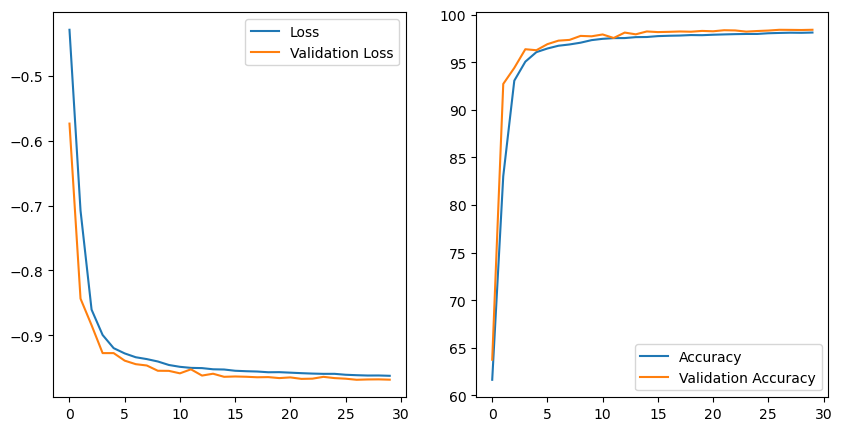

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

### Проверка модели на тестовых данных

In [21]:
vinTest = 'h:\\X-rey\\Lung Segmentation\\test\\'

In [22]:
test = []
for f in tqdm(os.listdir(vinTest)):
    im = cv2.imread('h:\\X-rey\\Lung Segmentation\\test\\'+f)
    im = cv2.resize(im, (112, 112))
    im = im[:,:,0]
    im = im.reshape(112,112,1)
    test.append(im)
print(np.array(test).shape)

100%|██████████| 96/96 [00:44<00:00,  2.18it/s]

(96, 112, 112, 1)


In [23]:
import gc
gc.collect()

1960

In [25]:
def mode_prediction(start,end,arr):
    tval = []
    for tpost in tqdm(range(start,end)):
        nval = test[tpost]
        val = (nval-127.0)/127.0
        tval.append(val)
    return tval

In [26]:
predictions = []
pending, batch = 0,1500
count = len(test)
start= 0
sum = 0
while(count>=0):
    end = start+batch
    sum = start-end
    if(end<len(test)):
        predictions.append(mode_prediction(start,end,test))
        start = end
    else:
        predictions.append(mode_prediction(start,len(test),test))
        start = end
        break
    count = count-sum
    gc.collect()
    
print(np.shape(predictions))

100%|██████████| 96/96 [00:00<00:00, 6400.26it/s]

(1, 96, 112, 112, 1)


In [27]:
final_vals = []
for k in predictions:
    for r in k:
        final_vals.append(r)
print(np.shape(final_vals))

(96, 112, 112, 1)


In [28]:
final_preds = model.predict(np.array(final_vals))

3/3 [==============================] - 3s 42ms/step


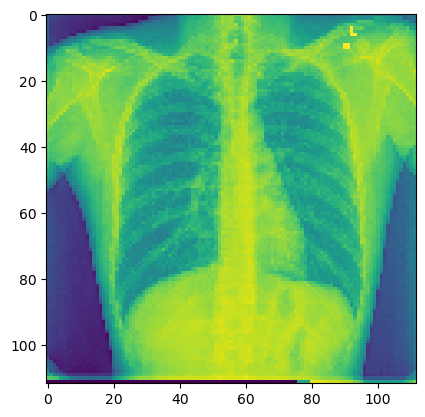

In [29]:
from PIL import Image
plt.imshow((np.squeeze(final_vals[0], axis=2)))

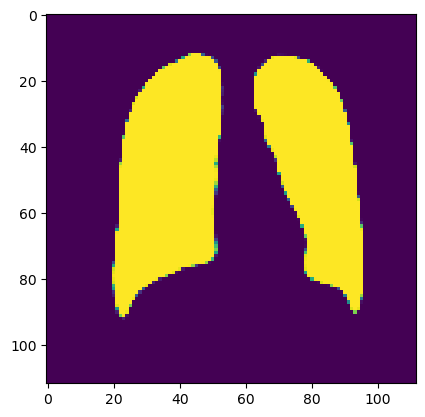

In [30]:
plt.imshow((np.squeeze(final_preds[0], axis=2)))

Выводы. Данных результатов удалось достичь благодаря:
* данные были предобработаны, размерность снижена до 112х112 пикселей
* в качестве модели использована сеть типа U-net с 4-мя свёрточными слоями, одним промежуточным и четыремя слоями апскейла. На выходе слой из одного нейрона для решения задани бинарной сегментации.
* функция активации во всех слоях кроме последнего - RELU. На выходе - Sigmoid
* для свёртки и апскейла размер ядра 3х3. Для пуллинга 2х2
* с уменьшением размера сетки настраиваемых параметров было кратно увеличено число нейронов в слое
* оптимизатор - adam, скорость обучения 1е*-5, размер батча - 16, количество эпох - 30